# Notebook Studio Completo: Classificazione Sinistri con Groq

Esegui step-by-step per analisi rapida e iterativa

---

## Setup e Import

In [1]:
import os
from groq_integration import GroqClassifier, quick_test_groq, full_dataset_analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from datetime import datetime

# Import del dataset generator
from medical_provider_dataset import create_mock_dataset, get_dataset_statistics, export_to_csv

print("✅ Import completati con successo!")

✅ Import completati con successo!


## Generazione Dataset

Generiamo il dataset di 1000 email simulate per la classificazione di sinistri medici.

**Caratteristiche del dataset:**
- **Prospettiva**: Medico/Ospedale (assicurato) → Compagnia Assicurativa
- **Totale email**: 1000
- **Dimensione 1 - Tipologia**:
  - 0: Sinistro Avvenuto (incidente già verificato)
  - 1: Circostanza Potenziale (situazione che potrebbe generare un sinistro)
- **Dimensione 2 - Riferimento Temporale**:
  - 0: Fatto Iniziale (prima segnalazione del caso)
  - 1: Follow-up (aggiornamento, integrazione documentale, evoluzione del caso)
- **Distribuzione**: 250 email per ogni combinazione (0-0, 0-1, 1-0, 1-1)

In [2]:
print("=" * 80)
print("🔬 GENERAZIONE DATASET MEDICAL PROVIDER")
print("=" * 80)

# Genera il dataset
print("\n📝 Generazione dataset di 1000 email simulate...")
df_full = create_mock_dataset()

# Mostra statistiche
stats = get_dataset_statistics(df_full)

print(f"\n✅ Dataset generato con successo!")
print(f"\n📊 STATISTICHE:")
print(f"   • Totale email: {stats['totale_email']}")
print(f"\n   📋 Per Tipologia:")
print(f"      - Sinistri Avvenuti: {stats['per_tipologia']['sinistri_avvenuti']} ({stats['per_tipologia']['sinistri_avvenuti']/stats['totale_email']*100:.1f}%)")
print(f"      - Circostanze Potenziali: {stats['per_tipologia']['circostanze_potenziali']} ({stats['per_tipologia']['circostanze_potenziali']/stats['totale_email']*100:.1f}%)")
print(f"\n   ⏰ Per Riferimento Temporale:")
print(f"      - Fatti Iniziali: {stats['per_riferimento']['fatti_iniziali']} ({stats['per_riferimento']['fatti_iniziali']/stats['totale_email']*100:.1f}%)")
print(f"      - Follow-up: {stats['per_riferimento']['followup']} ({stats['per_riferimento']['followup']/stats['totale_email']*100:.1f}%)")
print(f"\n   🔀 Per Combinazione:")
print(f"      - Sinistro Iniziale (0-0): {stats['per_combinazione']['sinistro_iniziale']}")
print(f"      - Sinistro Follow-up (0-1): {stats['per_combinazione']['sinistro_followup']}")
print(f"      - Circostanza Iniziale (1-0): {stats['per_combinazione']['circostanza_iniziale']}")
print(f"      - Circostanza Follow-up (1-1): {stats['per_combinazione']['circostanza_followup']}")

# Esporta il dataset
dataset_filename = "dataset_medical_provider_complete.csv"
export_to_csv(df_full, dataset_filename)
print(f"\n💾 Dataset salvato in: {dataset_filename}")

# Mostra primi esempi per categoria
print(f"\n📧 ESEMPI PER CATEGORIA:")
categories = [
    (0, 0, "Sinistro Avvenuto - Fatto Iniziale"),
    (0, 1, "Sinistro Avvenuto - Follow-up"),
    (1, 0, "Circostanza Potenziale - Fatto Iniziale"),
    (1, 1, "Circostanza Potenziale - Follow-up")
]

for tip, rif, label in categories:
    print(f"\n   ▸ {label}:")
    sample = df_full[(df_full['tipologia'] == tip) & (df_full['riferimento_temporale'] == rif)].head(1)
    for idx, row in sample.iterrows():
        print(f"      {row['testo'][:120]}...")

🔬 GENERAZIONE DATASET MEDICAL PROVIDER

📝 Generazione dataset di 1000 email simulate...

✅ Dataset generato con successo!

📊 STATISTICHE:
   • Totale email: 998

   📋 Per Tipologia:
      - Sinistri Avvenuti: 498 (49.9%)
      - Circostanze Potenziali: 500 (50.1%)

   ⏰ Per Riferimento Temporale:
      - Fatti Iniziali: 498 (49.9%)
      - Follow-up: 500 (50.1%)

   🔀 Per Combinazione:
      - Sinistro Iniziale (0-0): 248
      - Sinistro Follow-up (0-1): 250
      - Circostanza Iniziale (1-0): 250
      - Circostanza Follow-up (1-1): 250
✅ Dataset esportato in: dataset_medical_provider_complete.csv

💾 Dataset salvato in: dataset_medical_provider_complete.csv

📧 ESEMPI PER CATEGORIA:

   ▸ Sinistro Avvenuto - Fatto Iniziale:
      Alla Direzione Sinistri, Dr. Russo. Comunico danno iatrogeno del 15/07/2024 con conseguenze permanenti. Necessaria immed...

   ▸ Sinistro Avvenuto - Follow-up:
      Rif. DEN231683 - Dr. Greco. Aggiorno che il paziente ha sviluppato complicanza tardiva. la f

## STEP 1: Configurazione

In [3]:
print("=" * 80)
print("📚 STUDIO CLASSIFICAZIONE SINISTRI CON GROQ")
print("=" * 80)

# Inserisci la tua API key (o usa variabile ambiente)
GROQ_API_KEY = os.environ.get("GROQ_API_KEY", "inserisci-qui-se-non-usi-env")

# Inizializza il classifier per recuperare modelli disponibili
print("\n🔍 Recupero modelli disponibili dall'API Groq...")
temp_classifier = GroqClassifier(api_key=GROQ_API_KEY)

# Recupera modelli disponibili dinamicamente
available_models = temp_classifier.fetch_available_models()
recommended_models = temp_classifier.get_recommended_models()

print(f"\n✅ Modelli disponibili: {len(available_models)}")
print("\n📋 Lista completa modelli:")
for model in available_models:
    status = "🟢" if model.get("active", True) else "🔴"
    context = f" (ctx: {model.get('context_window', 'N/A')})" if model.get('context_window') else ""
    print(f"   {status} {model['id']}{context}")

print(f"\n⭐ Modelli consigliati per questo task ({len(recommended_models)}):")
for model in recommended_models:
    print(f"   • {model}")

# Configurazione studio
CONFIG = {
    "dataset_path": "dataset_medical_provider_complete.csv",  # Dataset generato
    "sample_sizes": [50, 100, 200],  # Diversi sample size per test
    "models_to_test": recommended_models,  # USA TUTTI i modelli consigliati
    "export_dir": "groq_study_results"
}

# Crea directory risultati e cache
os.makedirs(CONFIG["export_dir"], exist_ok=True)
os.makedirs(f"{CONFIG['export_dir']}/.cache", exist_ok=True)

print(f"\n✅ Configurazione caricata")
print(f"   Dataset: {CONFIG['dataset_path']}")
print(f"   Modelli selezionati: {len(CONFIG['models_to_test'])} (TUTTI)")
for i, model in enumerate(CONFIG['models_to_test'], 1):
    print(f"      {i}. {model}")
print(f"   Output: {CONFIG['export_dir']}/")
print(f"   Cache: {CONFIG['export_dir']}/.cache/")
print(f"\n💡 Dataset: Email da Medico/Ospedale → Compagnia Assicurativa")
print(f"   Classificazione multi-dimensionale:")
print(f"   - Tipologia: Sinistro Avvenuto vs Circostanza Potenziale")
print(f"   - Riferimento: Fatto Iniziale vs Follow-up")
print(f"\n🔄 Funzionalità Persistenza:")
print(f"   • Progresso salvato automaticamente ogni 10 email")
print(f"   • Possibilità di interrompere (Ctrl+C) e riprendere analisi")
print(f"   • Cache automatica per evitare riprocessamenti")
print(f"\n⚠️  NOTA: Con {len(CONFIG['models_to_test'])} modelli, l'analisi richiederà più tempo")
print(f"   Stima: ~{len(CONFIG['models_to_test']) * 2}-{len(CONFIG['models_to_test']) * 5} minuti per 100 email")


📚 STUDIO CLASSIFICAZIONE SINISTRI CON GROQ

🔍 Recupero modelli disponibili dall'API Groq...

✅ Modelli disponibili: 21

📋 Lista completa modelli:
   🟢 gemma2-9b-it (ctx: 8192)
   🟢 meta-llama/llama-guard-4-12b (ctx: 131072)
   🟢 openai/gpt-oss-20b (ctx: 131072)
   🟢 llama-3.1-8b-instant (ctx: 131072)
   🟢 groq/compound (ctx: 131072)
   🟢 moonshotai/kimi-k2-instruct (ctx: 131072)
   🟢 qwen/qwen3-32b (ctx: 131072)
   🟢 groq/compound-mini (ctx: 131072)
   🟢 meta-llama/llama-4-maverick-17b-128e-instruct (ctx: 131072)
   🟢 whisper-large-v3-turbo (ctx: 448)
   🟢 llama-3.3-70b-versatile (ctx: 131072)
   🟢 meta-llama/llama-prompt-guard-2-22m (ctx: 512)
   🟢 whisper-large-v3 (ctx: 448)
   🟢 allam-2-7b (ctx: 4096)
   🟢 meta-llama/llama-prompt-guard-2-86m (ctx: 512)
   🟢 openai/gpt-oss-120b (ctx: 131072)
   🟢 meta-llama/llama-4-scout-17b-16e-instruct (ctx: 131072)
   🟢 playai-tts-arabic (ctx: 8192)
   🟢 playai-tts (ctx: 8192)
   🟢 moonshotai/kimi-k2-instruct-0905 (ctx: 262144)
   🟢 deepseek-r1-di

### 🆕 Nuove Funzionalità

**1. Recupero Dinamico Modelli**
- I modelli vengono recuperati automaticamente dall'API Groq
- Non è più necessario aggiornare manualmente la lista dei modelli
- Vengono selezionati automaticamente i modelli più adatti al task

**2. Progress Bar con tqdm**
- Visualizzazione in tempo reale del progresso dell'analisi
- Stima del tempo rimanente (ETA)
- Indicazione della velocità di elaborazione

**3. Persistenza e Ripresa**
- Il progresso viene salvato automaticamente ogni 10 email
- Possibilità di interrompere l'analisi con `Ctrl+C`
- Ripresa automatica dal punto di interruzione
- Ottimizza i tempi e il consumo di chiamate API

**Come Usare:**
- **Interrompere**: Premi `Ctrl+C` durante l'analisi
- **Riprendere**: Riesegui la stessa cella, il sistema riprende automaticamente
- **Reset**: Elimina la cartella `.cache` per ricominciare da zero

## STEP 2: Verifica Connessione

In [4]:
print("\n" + "=" * 80)
print("STEP 1: Verifica Setup")
print("=" * 80)

if quick_test_groq(GROQ_API_KEY):
    print("\n✅ Setup verificato! Pronto per lo studio")
else:
    print("\n❌ Setup fallito. Verifica API key e connessione")
    raise Exception("Setup failed")


STEP 1: Verifica Setup
🧪 QUICK TEST GROQ API

📧 Email di test:
   Buongiorno, vi scrivo per segnalare un grave errore 
        chirurgico avvenuto il 15 marzo 2024. D...

⏳ Classificazione in corso...


📧 Email di test:
   Buongiorno, vi scrivo per segnalare un grave errore 
        chirurgico avvenuto il 15 marzo 2024. D...

⏳ Classificazione in corso...

✅ SUCCESSO!

📊 Risultato:
   Tipologia: 0 (Sinistro Avvenuto)
   Riferimento: 0 (Fatto Iniziale)
   Confidence: Tip=0.90, Rif=0.80
   Latenza: 0.421s
   Velocità: 1424 tokens/s

💡 Spiegazione: La presenza di verbi passati e di una data specifica indicano un sinistro già avvenuto.
   Indicatori: errore chirurgico, avvenuto, 15 marzo 2024

✅ Setup verificato! Pronto per lo studio
✅ SUCCESSO!

📊 Risultato:
   Tipologia: 0 (Sinistro Avvenuto)
   Riferimento: 0 (Fatto Iniziale)
   Confidence: Tip=0.90, Rif=0.80
   Latenza: 0.421s
   Velocità: 1424 tokens/s

💡 Spiegazione: La presenza di verbi passati e di una data specifica indicano un s

## 🧪 TEST RAPIDO: Verifica Nuove Funzionalità

Esegui questa cella per testare rapidamente le nuove funzionalità senza elaborare l'intero dataset.

In [5]:
print("=" * 80)
print("🧪 TEST RAPIDO NUOVE FUNZIONALITÀ")
print("=" * 80)

# Test 1: Recupero modelli
print("\n1️⃣ Test Recupero Modelli Dinamico")
print("-" * 80)
test_classifier = GroqClassifier(api_key=GROQ_API_KEY)
available = test_classifier.fetch_available_models()
recommended = test_classifier.get_recommended_models()

print(f"✅ Modelli disponibili: {len(available)}")
print(f"✅ Modelli consigliati: {len(recommended)}")
print(f"\nPrimi 3 consigliati:")
for i, model in enumerate(recommended[:3], 1):
    print(f"   {i}. {model}")

# Test 2: Progress bar (piccolo campione)
print("\n2️⃣ Test Progress Bar")
print("-" * 80)
print("Classificazione di 10 email di test...\n")

test_emails_quick = [
    "Segnalo grave errore chirurgico del 15/03/2024...",
    "Rif. pratica SIN12345, invio documentazione...",
    "Comunico situazione di potenziale rischio...",
] * 3 + ["Test finale"]  # 10 email totali

results_quick = test_classifier.classify_batch(
    emails=test_emails_quick,
    resume=True,
    save_interval=3
)

print(f"\n✅ Completato! {len(results_quick)} email classificate")

# Test 3: Verifica persistenza
print("\n3️⃣ Test Persistenza")
print("-" * 80)
cache_dir = f"{CONFIG['export_dir']}/.cache"
cache_files = os.listdir(cache_dir) if os.path.exists(cache_dir) else []
print(f"Directory cache: {cache_dir}")
print(f"File in cache: {len(cache_files)}")
if cache_files:
    print("Cache attiva - la ripresa funziona correttamente! ✅")
else:
    print("Nessuna cache (normale se test completato)")

print("\n" + "=" * 80)
print("✅ TEST COMPLETATO - Sistema pronto per analisi completa!")
print("=" * 80)


🧪 TEST RAPIDO NUOVE FUNZIONALITÀ

1️⃣ Test Recupero Modelli Dinamico
--------------------------------------------------------------------------------
✅ Modelli disponibili: 21
✅ Modelli consigliati: 9

Primi 3 consigliati:
   1. meta-llama/llama-prompt-guard-2-22m
   2. llama-3.3-70b-versatile
   3. meta-llama/llama-prompt-guard-2-86m

2️⃣ Test Progress Bar
--------------------------------------------------------------------------------
Classificazione di 10 email di test...


🚀 Nuova classificazione batch: 10 email
   Modello: llama-3.1-8b-instant
   Velocità attesa: ~120 email/min
   Salvataggio automatico ogni 3 email
✅ Modelli disponibili: 21
✅ Modelli consigliati: 9

Primi 3 consigliati:
   1. meta-llama/llama-prompt-guard-2-22m
   2. llama-3.3-70b-versatile
   3. meta-llama/llama-prompt-guard-2-86m

2️⃣ Test Progress Bar
--------------------------------------------------------------------------------
Classificazione di 10 email di test...


🚀 Nuova classificazione batch: 10 email

Classificazione (llama-3.1-8b-instant): 100%|██████████| 10/10 [00:04<00:00,  2.34email/s]

✅ Batch completato!
   Tempo totale: 4.3s
   Velocità media: 2.3 email/s
   Throughput: 141 email/min

✅ Completato! 10 email classificate

3️⃣ Test Persistenza
--------------------------------------------------------------------------------
Directory cache: groq_study_results/.cache
File in cache: 0
Nessuna cache (normale se test completato)

✅ TEST COMPLETATO - Sistema pronto per analisi completa!


## STEP 3: Carica e Analizza Dataset

Il dataset `medical_provider_dataset` contiene 1000 email simulate che rappresentano comunicazioni da parte di medici/ospedali verso compagnie assicurative.

**Classificazione Multi-Dimensionale:**

1. **Tipologia** (Natura dell'evento):
   - `0`: **Sinistro Avvenuto** - Danno/incidente già verificato che richiede apertura sinistro
   - `1`: **Circostanza Potenziale** - Situazione di rischio che potrebbe generare un sinistro futuro

2. **Riferimento Temporale** (Fase della comunicazione):
   - `0`: **Fatto Iniziale** - Prima segnalazione del caso
   - `1`: **Follow-up** - Aggiornamento, integrazione documentale, evoluzione del caso

**Combinazioni possibili:**
- **(0,0)** Sinistro Iniziale: "Segnalo evento avverso del 15/03... paziente richiede danni"
- **(0,1)** Sinistro Follow-up: "Rif. pratica SIN23456... invio documentazione integrativa"
- **(1,0)** Circostanza Iniziale: "Segnalo near miss che avrebbe potuto causare danno"
- **(1,1)** Circostanza Follow-up: "Rif. segnalazione... situazione risolta senza danni"

In [6]:
print("\n" + "=" * 80)
print("STEP 2: Analisi Dataset")
print("=" * 80)

# Carica il dataset generato (o usa df_full se già in memoria)
if 'df_full' in globals():
    df = df_full
    print("✅ Utilizzo dataset già generato in memoria")
else:
    df = pd.read_csv(CONFIG["dataset_path"])
    print(f"✅ Dataset caricato da file: {CONFIG['dataset_path']}")

print(f"\n📊 Statistiche Dataset:")
print(f"   Totale email: {len(df)}")
print(f"\n   Distribuzione Tipologia:")
for tip in [0, 1]:
    count = len(df[df['tipologia'] == tip])
    pct = count / len(df) * 100
    label = "Sinistro Avvenuto" if tip == 0 else "Circostanza Potenziale"
    print(f"      {tip} ({label}): {count} ({pct:.1f}%)")

print(f"\n   Distribuzione Riferimento:")
for rif in [0, 1]:
    count = len(df[df['riferimento_temporale'] == rif])
    pct = count / len(df) * 100
    label = "Fatto Iniziale" if rif == 0 else "Follow-up"
    print(f"      {rif} ({label}): {count} ({pct:.1f}%)")

print(f"\n   Distribuzione Combinata:")
for tip in [0, 1]:
    for rif in [0, 1]:
        count = len(df[(df['tipologia'] == tip) & (df['riferimento_temporale'] == rif)])
        tip_label = "Sin" if tip == 0 else "Circ"
        rif_label = "Iniz" if rif == 0 else "Foll"
        print(f"      {tip_label}-{rif_label} (Tip={tip}, Rif={rif}): {count}")

# Analisi aggiuntiva lunghezza testi
print(f"\n   📝 Lunghezza Testi:")
print(f"      Media: {df['testo'].str.len().mean():.0f} caratteri")
print(f"      Mediana: {df['testo'].str.len().median():.0f} caratteri")
print(f"      Min-Max: {df['testo'].str.len().min()}-{df['testo'].str.len().max()} caratteri")


STEP 2: Analisi Dataset
✅ Utilizzo dataset già generato in memoria

📊 Statistiche Dataset:
   Totale email: 998

   Distribuzione Tipologia:
      0 (Sinistro Avvenuto): 498 (49.9%)
      1 (Circostanza Potenziale): 500 (50.1%)

   Distribuzione Riferimento:
      0 (Fatto Iniziale): 498 (49.9%)
      1 (Follow-up): 500 (50.1%)

   Distribuzione Combinata:
      Sin-Iniz (Tip=0, Rif=0): 248
      Sin-Foll (Tip=0, Rif=1): 250
      Circ-Iniz (Tip=1, Rif=0): 250
      Circ-Foll (Tip=1, Rif=1): 250

   📝 Lunghezza Testi:
      Media: 196 caratteri
      Mediana: 192 caratteri
      Min-Max: 161-347 caratteri


In [7]:
# Visualizza alcuni esempi rappresentativi
print("\n" + "=" * 80)
print("📧 ESEMPI RAPPRESENTATIVI DAL DATASET")
print("=" * 80)

categories_examples = [
    (0, 0, "Sinistro Avvenuto - Fatto Iniziale", "🚨"),
    (0, 1, "Sinistro Avvenuto - Follow-up", "📋"),
    (1, 0, "Circostanza Potenziale - Fatto Iniziale", "⚠️"),
    (1, 1, "Circostanza Potenziale - Follow-up", "📝")
]

for tip, rif, label, icon in categories_examples:
    print(f"\n{icon} {label}:")
    print("-" * 80)
    sample = df[(df['tipologia'] == tip) & (df['riferimento_temporale'] == rif)].sample(1, random_state=42)
    for idx, row in sample.iterrows():
        print(f"{row['testo']}")
        print(f"\n   Label: Tipologia={tip}, Riferimento={rif}")


📧 ESEMPI RAPPRESENTATIVI DAL DATASET

🚨 Sinistro Avvenuto - Fatto Iniziale:
--------------------------------------------------------------------------------
Alla Direzione Sinistri, Dr. De Luca. Comunico danno iatrogeno del 20/04/2023 con conseguenze permanenti. Necessaria immediata attivazione copertura RC professionale.

   Label: Tipologia=0, Riferimento=0

📋 Sinistro Avvenuto - Follow-up:
--------------------------------------------------------------------------------
Spett.le compagnia, rif. SIN244638 - Dr. Russo. Comunico peggioramento condizioni cliniche paziente con necessità ricovero urgente per complicanze. Famiglia richiede aggiornamento valutazione danni.

   Label: Tipologia=0, Riferimento=1

⚠️ Circostanza Potenziale - Fatto Iniziale:
--------------------------------------------------------------------------------
Oggetto: Segnalazione preventiva. Dr. De Luca. Ho rilevato irregolarità procedurale che potrebbe generare contestazioni. Nessun danno verificato ma chiedo vs p

## STEP 4: Esperimento 1 - Test Velocità vs Accuratezza

In [8]:
print("\n" + "=" * 80)
print("STEP 3: Esperimento - Velocità vs Accuratezza")
print("=" * 80)

# Prepara campione test bilanciato (100 email)
sample_size = 100
samples_per_cat = sample_size // 4

test_sample = []
for tip in [0, 1]:
    for rif in [0, 1]:
        subset = df[(df['tipologia'] == tip) & 
                   (df['riferimento_temporale'] == rif)].sample(
                       samples_per_cat, random_state=42
                   )
        test_sample.append(subset)

test_df = pd.concat(test_sample).reset_index(drop=True)
test_emails = test_df['testo'].tolist()
test_labels = list(zip(test_df['tipologia'], test_df['riferimento_temporale']))

print(f"\n📧 Campione test preparato: {len(test_df)} email")


STEP 3: Esperimento - Velocità vs Accuratezza

📧 Campione test preparato: 100 email


In [9]:
# Confronta modelli con progress bar e persistenza
print("\n💡 Nota: L'analisi può essere interrotta con Ctrl+C e ripresa rieseguendo questa cella")
print("   Il progresso viene salvato automaticamente ogni 10 email\n")

classifier = GroqClassifier(api_key=GROQ_API_KEY, cache_dir=f"{CONFIG['export_dir']}/.cache")

# Esegui confronto con gestione interruzioni
comparison_df = classifier.compare_models(
    test_emails=test_emails,
    true_labels=test_labels,
    models=CONFIG["models_to_test"],
    resume=True  # Riprende automaticamente se interrotto
)

# Salva risultati
comparison_file = f"{CONFIG['export_dir']}/model_comparison.csv"
comparison_df.to_csv(comparison_file, index=False)
print(f"\n💾 Confronto salvato: {comparison_file}")

# Visualizza confronto
comparison_df


💡 Nota: L'analisi può essere interrotta con Ctrl+C e ripresa rieseguendo questa cella
   Il progresso viene salvato automaticamente ogni 10 email


🏁 BENCHMARK MULTI-MODELLO GROQ
Modelli da testare: 9
Email per modello: 100
Totale classificazioni: 900

🏁 BENCHMARK MULTI-MODELLO GROQ
Modelli da testare: 9
Email per modello: 100
Totale classificazioni: 900


Modelli testati:   0%|          | 0/9 [00:00<?, ?model/s]


🤖 Testing: meta-llama/llama-prompt-guard-2-86m
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: meta-llama/llama-prompt-guard-2-86m
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Classificazione (meta-llama/llama-prompt-guard-2-86m): 100%|██████████| 100/100 [00:17<00:00,  5.73email/s]
Classificazione (meta-llama/llama-prompt-guard-2-86m): 100%|██████████| 100/100 [00:17<00:00,  5.73email/s]
Modelli testati:  11%|█         | 1/9 [00:17<02:19, 17.47s/model]

✅ Batch completato!
   Tempo totale: 17.5s
   Velocità media: 5.7 email/s
   Throughput: 344 email/min

⚠️  Nessuna classificazione riuscita

🤖 Testing: gemma2-9b-it
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: gemma2-9b-it
   Velocità attesa: ~100 email/min
   Salvataggio automatico ogni 10 email


Modelli testati:  22%|██▏       | 2/9 [03:40<14:44, 126.37s/model]

✅ Batch completato!
   Tempo totale: 202.6s
   Velocità media: 0.5 email/s
   Throughput: 30 email/min

📊 METRICHE PERFORMANCE:
   Accuracy Tipologia:          85.0%
   Accuracy Riferimento:        98.0%
   Accuracy Entrambe:           85.0%

   Confidence Media Tipologia:  0.89
   Confidence Media Riferimento:0.85

   Latenza Media:               1.921s
   Token Medi per Email:        564

🤖 Testing: meta-llama/llama-4-maverick-17b-128e-instruct
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: meta-llama/llama-4-maverick-17b-128e-instruct
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Classificazione (meta-llama/llama-4-maverick-17b-128e-instruct): 100%|██████████| 100/100 [07:46<00:00,  4.66s/email]
Classificazione (meta-llama/llama-4-maverick-17b-128e-instruct): 100%|██████████| 100/100 [07:46<00:00,  4.66s/email]
Modelli testati:  33%|███▎      | 3/9 [11:26<28:09, 281.66s/model]

✅ Batch completato!
   Tempo totale: 466.4s
   Velocità media: 0.2 email/s
   Throughput: 13 email/min

📊 METRICHE PERFORMANCE:
   Accuracy Tipologia:          95.0%
   Accuracy Riferimento:        99.0%
   Accuracy Entrambe:           95.0%

   Confidence Media Tipologia:  0.87
   Confidence Media Riferimento:0.99

   Latenza Media:               4.560s
   Token Medi per Email:        521

🤖 Testing: llama-3.1-8b-instant
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: llama-3.1-8b-instant
   Velocità attesa: ~120 email/min
   Salvataggio automatico ogni 10 email


Modelli testati:  44%|████▍     | 4/9 [20:30<32:06, 385.22s/model]

✅ Batch completato!
   Tempo totale: 544.0s
   Velocità media: 0.2 email/s
   Throughput: 11 email/min

📊 METRICHE PERFORMANCE:
   Accuracy Tipologia:          82.0%
   Accuracy Riferimento:        91.0%
   Accuracy Entrambe:           75.0%

   Confidence Media Tipologia:  0.85
   Confidence Media Riferimento:0.85

   Latenza Media:               5.335s
   Token Medi per Email:        605

🤖 Testing: meta-llama/llama-prompt-guard-2-22m
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: meta-llama/llama-prompt-guard-2-22m
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Classificazione (meta-llama/llama-prompt-guard-2-22m): 100%|██████████| 100/100 [00:17<00:00,  5.87email/s]
Classificazione (meta-llama/llama-prompt-guard-2-22m): 100%|██████████| 100/100 [00:17<00:00,  5.87email/s]
Modelli testati:  56%|█████▌    | 5/9 [20:47<16:49, 252.46s/model]

✅ Batch completato!
   Tempo totale: 17.1s
   Velocità media: 5.9 email/s
   Throughput: 352 email/min

⚠️  Nessuna classificazione riuscita

🤖 Testing: meta-llama/llama-guard-4-12b
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: meta-llama/llama-guard-4-12b
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Modelli testati:  67%|██████▋   | 6/9 [23:53<11:29, 229.91s/model]

✅ Batch completato!
   Tempo totale: 186.1s
   Velocità media: 0.5 email/s
   Throughput: 32 email/min

⚠️  Nessuna classificazione riuscita

🤖 Testing: llama-3.3-70b-versatile
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: llama-3.3-70b-versatile
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Modelli testati:  78%|███████▊  | 7/9 [24:12<05:21, 160.89s/model]

✅ Batch completato!
   Tempo totale: 18.8s
   Velocità media: 5.3 email/s
   Throughput: 319 email/min

📊 METRICHE PERFORMANCE:
   Accuracy Tipologia:          100.0%
   Accuracy Riferimento:        100.0%
   Accuracy Entrambe:           100.0%

   Confidence Media Tipologia:  0.90
   Confidence Media Riferimento:0.80

   Latenza Media:               0.349s
   Token Medi per Email:        577

🤖 Testing: meta-llama/llama-4-scout-17b-16e-instruct
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: meta-llama/llama-4-scout-17b-16e-instruct
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Classificazione (meta-llama/llama-4-scout-17b-16e-instruct): 100%|██████████| 100/100 [03:18<00:00,  1.98s/email]
Classificazione (meta-llama/llama-4-scout-17b-16e-instruct): 100%|██████████| 100/100 [03:18<00:00,  1.98s/email]
Modelli testati:  89%|████████▉ | 8/9 [27:30<02:52, 172.73s/model]

✅ Batch completato!
   Tempo totale: 198.1s
   Velocità media: 0.5 email/s
   Throughput: 30 email/min

📊 METRICHE PERFORMANCE:
   Accuracy Tipologia:          80.0%
   Accuracy Riferimento:        99.0%
   Accuracy Entrambe:           80.0%

   Confidence Media Tipologia:  0.88
   Confidence Media Riferimento:0.92

   Latenza Media:               1.876s
   Token Medi per Email:        527

🤖 Testing: deepseek-r1-distill-llama-70b
--------------------------------------------------------------------------------

🚀 Nuova classificazione batch: 100 email
   Modello: deepseek-r1-distill-llama-70b
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Modelli testati: 100%|██████████| 9/9 [39:02<00:00, 260.24s/model]

✅ Batch completato!
   Tempo totale: 691.6s
   Velocità media: 0.1 email/s
   Throughput: 9 email/min

📊 METRICHE PERFORMANCE:
   Accuracy Tipologia:          100.0%
   Accuracy Riferimento:        100.0%
   Accuracy Entrambe:           100.0%

   Confidence Media Tipologia:  1.00
   Confidence Media Riferimento:1.00

   Latenza Media:               5.364s
   Token Medi per Email:        738

📊 TABELLA COMPARATIVA
                                        model  accuracy_tipologia  accuracy_riferimento  accuracy_both  avg_confidence  avg_latency  throughput  avg_tokens
                                 gemma2-9b-it                85.0                  98.0           85.0         0.86900     1.921483    0.520431      564.06
meta-llama/llama-4-maverick-17b-128e-instruct                95.0                  99.0           95.0         0.92875     4.560125    0.219292      521.39
                         llama-3.1-8b-instant                82.0                  91.0           75.0         0.8

,model,accuracy_tipologia,accuracy_riferimento,accuracy_both,avg_confidence,avg_latency,throughput,avg_tokens
0,gemma2-9b-it,85.0,98.0,85.0,0.86900,1.921483,0.520431,564.06
1,meta-llama/llama-4-maverick-17b-128e-instruct,95.0,99.0,95.0,0.92875,4.560125,0.219292,521.39
2,llama-3.1-8b-instant,82.0,91.0,75.0,0.85000,5.335422,0.187427,605.05
3,llama-3.3-70b-versatile,100.0,100.0,100.0,0.85000,0.348756,2.867333,577.20
4,meta-llama/llama-4-scout-17b-16e-instruct,80.0,99.0,80.0,0.89950,1.875952,0.533063,526.75
5,deepseek-r1-distill-llama-70b,100.0,100.0,100.0,1.00000,5.363986,0.186429,738.00


## STEP 5: Esperimento 2 - Analisi Errori

In [10]:
print("\n" + "=" * 80)
print("STEP 4: Analisi Errori Dettagliata")
print("=" * 80)

# Usa il modello migliore dal confronto
best_model = comparison_df.loc[comparison_df['accuracy_both'].idxmax(), 'model']
print(f"\n🎯 Usando modello migliore: {best_model}")

classifier.model = best_model

print("\n💡 Nota: L'analisi può essere interrotta con Ctrl+C e ripresa rieseguendo questa cella\n")

# Classifica con progress bar e gestione interruzioni
results_df = classifier.classify_batch(
    test_emails, 
    test_labels,
    resume=True,
    save_interval=10
)



STEP 4: Analisi Errori Dettagliata

🎯 Usando modello migliore: llama-3.3-70b-versatile

💡 Nota: L'analisi può essere interrotta con Ctrl+C e ripresa rieseguendo questa cella


🚀 Nuova classificazione batch: 100 email
   Modello: llama-3.3-70b-versatile
   Velocità attesa: ~60 email/min
   Salvataggio automatico ogni 10 email


Classificazione (llama-3.3-70b-versatile): 100%|██████████| 100/100 [00:18<00:00,  5.36email/s]

✅ Batch completato!
   Tempo totale: 18.7s
   Velocità media: 5.4 email/s
   Throughput: 321 email/min

📊 METRICHE PERFORMANCE:
   Accuracy Tipologia:          100.0%
   Accuracy Riferimento:        100.0%
   Accuracy Entrambe:           100.0%

   Confidence Media Tipologia:  0.90
   Confidence Media Riferimento:0.80

   Latenza Media:               0.384s
   Token Medi per Email:        577


In [11]:
# Identifica errori
errors_df = results_df[
    (results_df['success'] == True) & 
    ((results_df['correct_tipologia'] == False) | 
     (results_df['correct_riferimento'] == False))
]

print(f"\n❌ Analisi Errori:")
print(f"   Totale errori: {len(errors_df)}/{len(results_df)}")

if len(errors_df) > 0:
    print(f"\n   Top 5 Errori:")
    for idx, row in errors_df.head(5).iterrows():
        print(f"\n   Email: {row['email_text']}")
        print(f"   Predetto: Tip={row['tipologia']}, Rif={row['riferimento_temporale']}")
        print(f"   Corretto: Tip={row['true_tipologia']}, Rif={row['true_riferimento']}")
        print(f"   Spiegazione: {row.get('spiegazione', 'N/A')}")
        print(f"   Confidence: Tip={row.get('confidence_tipologia', 0):.2f}, "
              f"Rif={row.get('confidence_riferimento', 0):.2f}")

# Salva errori per analisi
errors_file = f"{CONFIG['export_dir']}/classification_errors.csv"
errors_df.to_csv(errors_file, index=False)
print(f"\n💾 Errori salvati: {errors_file}")


❌ Analisi Errori:
   Totale errori: 0/100

💾 Errori salvati: groq_study_results/classification_errors.csv


## STEP 6: Esperimento 3 - Matrice di Confusione

In [13]:
print("\n" + "=" * 80)
print("STEP 5: Matrici di Confusione")
print("=" * 80)

successful = results_df[results_df['success'] == True]

# Matrice per Tipologia
y_true_tip = successful['true_tipologia']
y_pred_tip = successful['tipologia']

cm_tip = confusion_matrix(y_true_tip, y_pred_tip, labels=[0, 1])

print("\n📊 Matrice Confusione - TIPOLOGIA:")
print("                    Predetto")
print("                  0 (Sin)  1 (Circ)")
print(f"Vero  0 (Sin)    {cm_tip[0,0]:5d}    {cm_tip[0,1]:5d}")
print(f"      1 (Circ)   {cm_tip[1,0]:5d}    {cm_tip[1,1]:5d}")

# Matrice per Riferimento Temporale
y_true_rif = successful['true_riferimento']
y_pred_rif = successful['riferimento_temporale']

cm_rif = confusion_matrix(y_true_rif, y_pred_rif, labels=[0, 1])

print("\n📊 Matrice Confusione - RIFERIMENTO TEMPORALE:")
print("                    Predetto")
print("                  0 (Iniz)  1 (Foll)")
print(f"Vero  0 (Iniz)   {cm_rif[0,0]:5d}    {cm_rif[0,1]:5d}")
print(f"      1 (Foll)   {cm_rif[1,0]:5d}    {cm_rif[1,1]:5d}")



STEP 5: Matrici di Confusione

📊 Matrice Confusione - TIPOLOGIA:
                    Predetto
                  0 (Sin)  1 (Circ)
Vero  0 (Sin)        5        0
      1 (Circ)       0        0

📊 Matrice Confusione - RIFERIMENTO TEMPORALE:
                    Predetto
                  0 (Iniz)  1 (Foll)
Vero  0 (Iniz)       5        0
      1 (Foll)       0        0



💾 Grafici salvati: groq_study_results/confusion_matrices.png


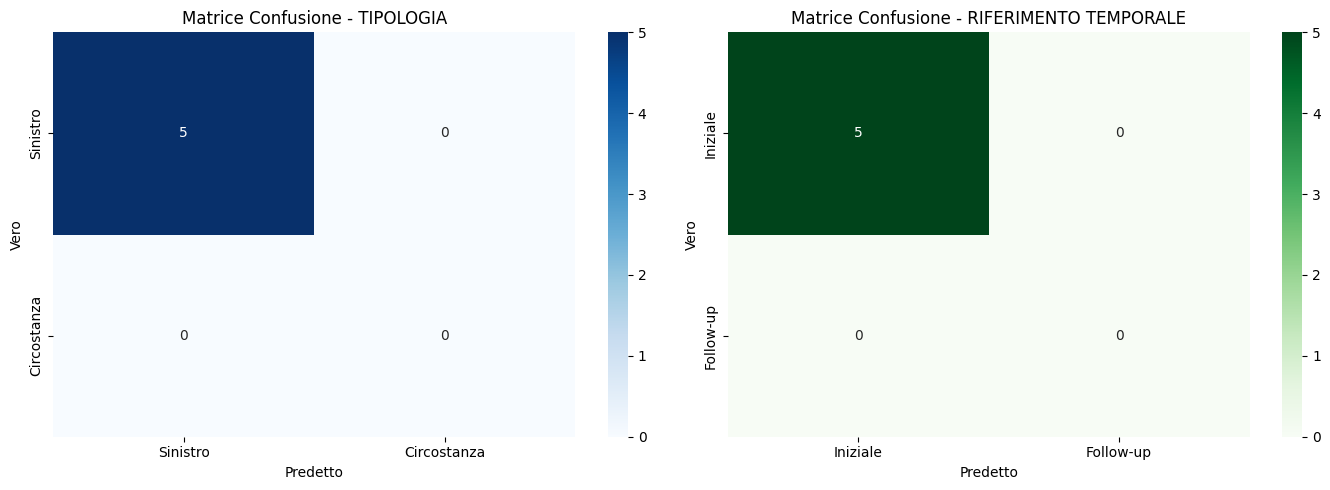

In [14]:
# Visualizza matrici con heatmap
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Tipologia
    sns.heatmap(cm_tip, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Sinistro', 'Circostanza'],
                yticklabels=['Sinistro', 'Circostanza'])
    axes[0].set_title('Matrice Confusione - TIPOLOGIA')
    axes[0].set_ylabel('Vero')
    axes[0].set_xlabel('Predetto')
    
    # Riferimento
    sns.heatmap(cm_rif, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Iniziale', 'Follow-up'],
                yticklabels=['Iniziale', 'Follow-up'])
    axes[1].set_title('Matrice Confusione - RIFERIMENTO TEMPORALE')
    axes[1].set_ylabel('Vero')
    axes[1].set_xlabel('Predetto')
    
    plt.tight_layout()
    
    confusion_plot = f"{CONFIG['export_dir']}/confusion_matrices.png"
    plt.savefig(confusion_plot, dpi=300, bbox_inches='tight')
    print(f"\n💾 Grafici salvati: {confusion_plot}")
    plt.show()
    
except Exception as e:
    print(f"\n⚠️  Grafici non generati (matplotlib non disponibile): {e}")

## STEP 7: Esperimento 4 - Analisi Confidence

In [15]:
print("\n" + "=" * 80)
print("STEP 6: Analisi Confidence Scores")
print("=" * 80)

# Analizza relazione confidence/correttezza
correct_predictions = successful[
    (successful['correct_tipologia'] == True) & 
    (successful['correct_riferimento'] == True)
]
incorrect_predictions = successful[
    (successful['correct_tipologia'] == False) | 
    (successful['correct_riferimento'] == False)
]

print(f"\n📈 Confidence Scores:")
print(f"\n   Predizioni CORRETTE:")
print(f"      Media Confidence Tipologia:    {correct_predictions['confidence_tipologia'].mean():.3f}")
print(f"      Media Confidence Riferimento:  {correct_predictions['confidence_riferimento'].mean():.3f}")

if len(incorrect_predictions) > 0:
    print(f"\n   Predizioni ERRATE:")
    print(f"      Media Confidence Tipologia:    {incorrect_predictions['confidence_tipologia'].mean():.3f}")
    print(f"      Media Confidence Riferimento:  {incorrect_predictions['confidence_riferimento'].mean():.3f}")
    
    # Identifica predizioni con alta confidence ma errate (falsi positivi pericolosi)
    high_conf_errors = incorrect_predictions[
        (incorrect_predictions['confidence_tipologia'] > 0.8) |
        (incorrect_predictions['confidence_riferimento'] > 0.8)
    ]
    
    if len(high_conf_errors) > 0:
        print(f"\n   ⚠️  ALERT: {len(high_conf_errors)} errori con alta confidence!")
        print(f"      Questi richiedono analisi approfondita:")
        for idx, row in high_conf_errors.head(3).iterrows():
            print(f"\n      • {row['email_text']}")
            print(f"        Confidence: {row['confidence_tipologia']:.2f}, {row['confidence_riferimento']:.2f}")


STEP 6: Analisi Confidence Scores

📈 Confidence Scores:

   Predizioni CORRETTE:
      Media Confidence Tipologia:    0.900
      Media Confidence Riferimento:  0.800



💾 Analisi confidence salvata: groq_study_results/confidence_analysis.png


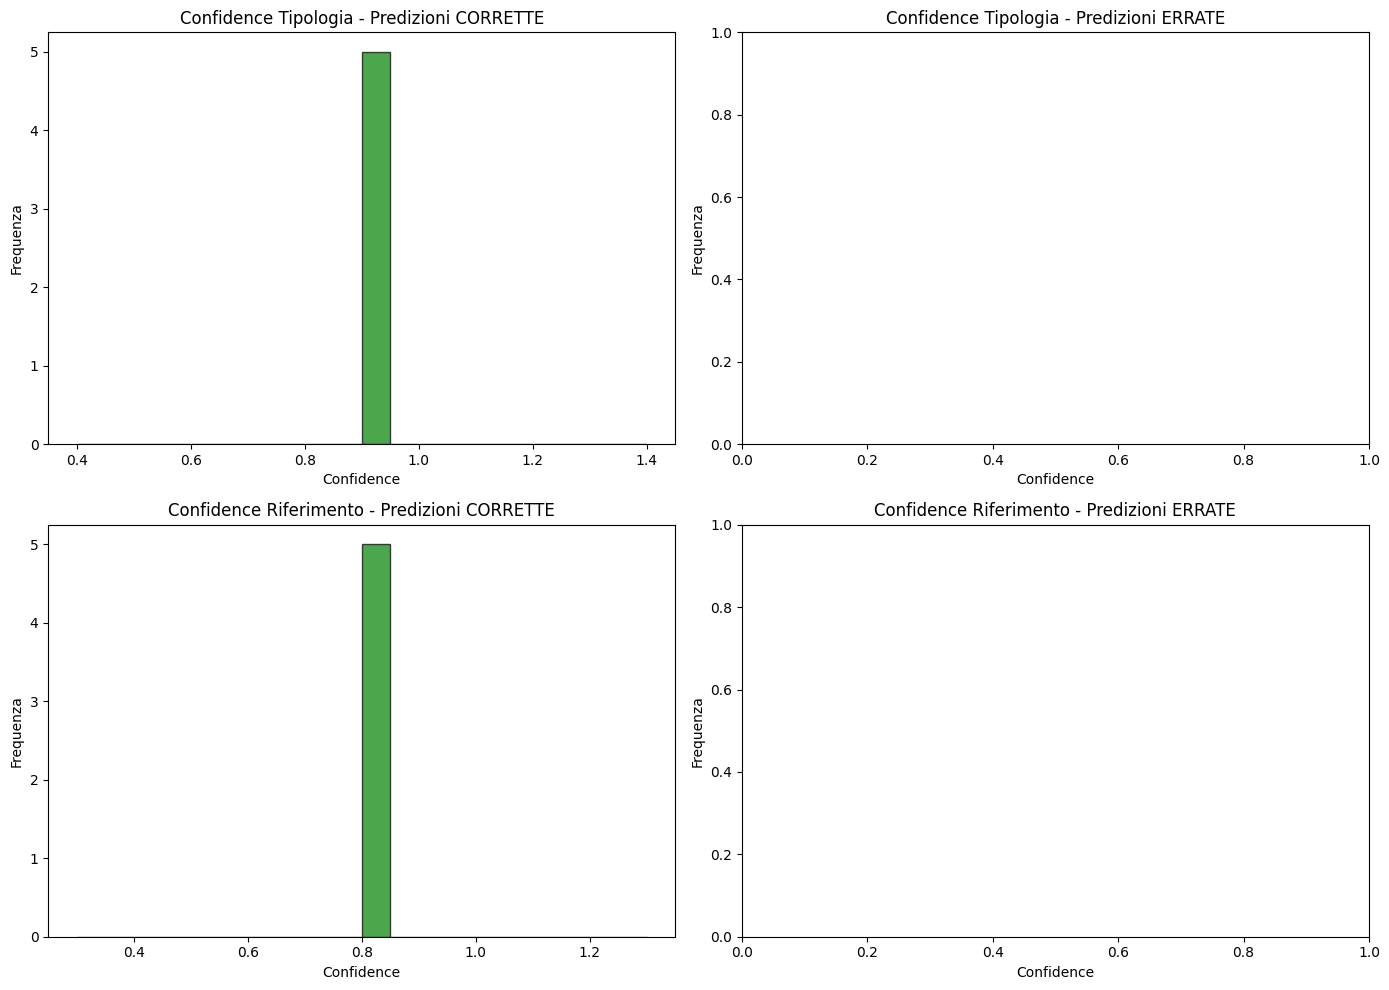

In [16]:
# Grafico distribuzione confidence
try:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Tipologia - Corrette
    axes[0, 0].hist(correct_predictions['confidence_tipologia'], bins=20, 
                    color='green', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Confidence Tipologia - Predizioni CORRETTE')
    axes[0, 0].set_xlabel('Confidence')
    axes[0, 0].set_ylabel('Frequenza')
    
    # Tipologia - Errate
    if len(incorrect_predictions) > 0:
        axes[0, 1].hist(incorrect_predictions['confidence_tipologia'], bins=20,
                       color='red', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Confidence Tipologia - Predizioni ERRATE')
    axes[0, 1].set_xlabel('Confidence')
    axes[0, 1].set_ylabel('Frequenza')
    
    # Riferimento - Corrette
    axes[1, 0].hist(correct_predictions['confidence_riferimento'], bins=20,
                    color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Confidence Riferimento - Predizioni CORRETTE')
    axes[1, 0].set_xlabel('Confidence')
    axes[1, 0].set_ylabel('Frequenza')
    
    # Riferimento - Errate
    if len(incorrect_predictions) > 0:
        axes[1, 1].hist(incorrect_predictions['confidence_riferimento'], bins=20,
                       color='red', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Confidence Riferimento - Predizioni ERRATE')
    axes[1, 1].set_xlabel('Confidence')
    axes[1, 1].set_ylabel('Frequenza')
    
    plt.tight_layout()
    
    confidence_plot = f"{CONFIG['export_dir']}/confidence_analysis.png"
    plt.savefig(confidence_plot, dpi=300, bbox_inches='tight')
    print(f"\n💾 Analisi confidence salvata: {confidence_plot}")
    plt.show()
    
except Exception as e:
    print(f"\n⚠️  Grafici confidence non generati: {e}")

## STEP 8: Esperimento 5 - Test su Dataset Completo (Opzionale)

In [ ]:
print("\n" + "=" * 80)
print("STEP 7: Test su Dataset Completo (Campione 500)")
print("=" * 80)

# Modifica questa variabile per eseguire il test
run_large_sample = False  # Cambia in True per eseguire

if run_large_sample:
    print("\n🚀 Inizio test su campione esteso...")
    
    # Prepara campione più grande
    large_sample_size = 500
    samples_per_cat = large_sample_size // 4
    
    large_sample = []
    for tip in [0, 1]:
        for rif in [0, 1]:
            subset = df[(df['tipologia'] == tip) & 
                       (df['riferimento_temporale'] == rif)].sample(
                           min(samples_per_cat, len(df[(df['tipologia'] == tip) & 
                                                       (df['riferimento_temporale'] == rif)])),
                           random_state=42
                       )
            large_sample.append(subset)
    
    large_df = pd.concat(large_sample).reset_index(drop=True)
    large_emails = large_df['testo'].tolist()
    large_labels = list(zip(large_df['tipologia'], large_df['riferimento_temporale']))
    
    print(f"\n📧 Campione esteso: {len(large_df)} email")
    
    # Classifica con modello migliore
    large_results = classifier.classify_batch(large_emails, large_labels)
    
    # Salva risultati
    large_results_file = f"{CONFIG['export_dir']}/large_sample_results.csv"
    large_results.to_csv(large_results_file, index=False)
    print(f"\n💾 Risultati campione esteso salvati: {large_results_file}")
    
else:
    print("\n⏭️  Saltato test campione esteso (cambia run_large_sample = True per eseguire)")

## STEP 9: Esperimento 6 - Analisi Indicatori Chiave

In [17]:
print("\n" + "=" * 80)
print("STEP 8: Analisi Indicatori Chiave Più Frequenti")
print("=" * 80)

# Estrai tutti gli indicatori
all_indicators = []
for indicators in successful['indicatori_chiave']:
    if isinstance(indicators, list):
        all_indicators.extend([ind.lower() for ind in indicators])

# Conta frequenze
indicator_counts = Counter(all_indicators)

print(f"\n🔑 Top 20 Indicatori Più Usati dal Modello:")
for indicator, count in indicator_counts.most_common(20):
    print(f"   {indicator:<40} {count:>3} volte")

# Salva indicatori
indicators_df = pd.DataFrame(indicator_counts.most_common(), 
                             columns=['Indicatore', 'Frequenza'])
indicators_file = f"{CONFIG['export_dir']}/key_indicators.csv"
indicators_df.to_csv(indicators_file, index=False)
print(f"\n💾 Indicatori salvati: {indicators_file}")


STEP 8: Analisi Indicatori Chiave Più Frequenti

🔑 Top 20 Indicatori Più Usati dal Modello:
   data evento                                3 volte
   sinistro medico                            2 volte
   comunico complicanza                       2 volte
   esiti invalidanti                          2 volte
   danno iatrogeno                            1 volte
   conseguenze permanenti                     1 volte
   evento avverso                             1 volte
   richiesta danni                            1 volte
   ustione chimica iatrogena                  1 volte
   richiesta risarcimento                     1 volte

💾 Indicatori salvati: groq_study_results/key_indicators.csv


## STEP 10: Report Finale

In [18]:
print("\n" + "=" * 80)
print("📋 REPORT FINALE STUDIO")
print("=" * 80)

# Calcola metriche finali
final_accuracy_tip = successful['correct_tipologia'].mean() * 100
final_accuracy_rif = successful['correct_riferimento'].mean() * 100
final_accuracy_both = (successful['correct_tipologia'] & 
                       successful['correct_riferimento']).mean() * 100

avg_latency = successful['latency'].mean()
total_time = successful['latency'].sum()
avg_tokens = successful['tokens_used'].mean()
total_tokens = successful['tokens_used'].sum()

# Stima costo (Groq pricing approssimativo)
estimated_cost_per_1k_tokens = 0.0001  # $0.0001 per 1K tokens (molto basso)
estimated_total_cost = (total_tokens / 1000) * estimated_cost_per_1k_tokens

print(f"\n🎯 METRICHE FINALI:")
print(f"   Modello utilizzato:              {best_model}")
print(f"   Email classificate:              {len(successful)}")
print(f"\n   Accuracy Tipologia:              {final_accuracy_tip:.2f}%")
print(f"   Accuracy Riferimento:            {final_accuracy_rif:.2f}%")
print(f"   Accuracy Entrambe:               {final_accuracy_both:.2f}%")

print(f"\n⚡ PERFORMANCE:")
print(f"   Latenza media:                   {avg_latency:.3f}s")
print(f"   Tempo totale:                    {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"   Throughput:                      {len(successful)/total_time:.1f} email/s")
print(f"   Velocità equivalente:            {len(successful)/total_time*60:.0f} email/ora")

print(f"\n💰 COSTI:")
print(f"   Token totali usati:              {total_tokens:,.0f}")
print(f"   Token medi per email:            {avg_tokens:.0f}")
print(f"   Costo stimato totale:            ${estimated_total_cost:.4f}")
print(f"   Costo per 1000 email:            ${estimated_cost_per_1k_tokens * avg_tokens:.4f}")

print(f"\n📁 FILE GENERATI:")
print(f"   • {comparison_file}")
print(f"   • {errors_file}")
print(f"   • {indicators_file}")
if 'confusion_plot' in locals():
    print(f"   • {confusion_plot}")
if 'confidence_plot' in locals():
    print(f"   • {confidence_plot}")

print(f"\n💡 CONCLUSIONI:")

if final_accuracy_both >= 90:
    print(f"   ✅ Accuracy eccellente ({final_accuracy_both:.1f}%)")
    print(f"   ✅ Modello pronto per produzione")
elif final_accuracy_both >= 80:
    print(f"   ⚠️  Accuracy buona ({final_accuracy_both:.1f}%)")
    print(f"   💡 Considera fine-tuning per migliorare")
else:
    print(f"   ❌ Accuracy insufficiente ({final_accuracy_both:.1f}%)")
    print(f"   💡 Necessario prompt engineering o fine-tuning")

print(f"\n🚀 PROSSIMI PASSI CONSIGLIATI:")
print(f"   1. Analizza errori in {errors_file}")
print(f"   2. Ottimizza system prompt basandoti su indicatori")
print(f"   3. Se accuracy OK → Deploy in produzione")
print(f"   4. Se accuracy bassa → Fine-tuning con Unsloth/LoRA")
print(f"   5. Setup sistema apprendimento continuo")

print("\n" + "=" * 80)
print("✅ STUDIO COMPLETATO!")
print("=" * 80)


📋 REPORT FINALE STUDIO

🎯 METRICHE FINALI:
   Modello utilizzato:              llama-3.3-70b-versatile
   Email classificate:              5

   Accuracy Tipologia:              100.00%
   Accuracy Riferimento:            100.00%
   Accuracy Entrambe:               100.00%

⚡ PERFORMANCE:
   Latenza media:                   0.384s
   Tempo totale:                    1.9s (0.0 min)
   Throughput:                      2.6 email/s
   Velocità equivalente:            156 email/ora

💰 COSTI:
   Token totali usati:              2,883
   Token medi per email:            577
   Costo stimato totale:            $0.0003
   Costo per 1000 email:            $0.0577

📁 FILE GENERATI:
   • groq_study_results/model_comparison.csv
   • groq_study_results/classification_errors.csv
   • groq_study_results/key_indicators.csv
   • groq_study_results/confusion_matrices.png
   • groq_study_results/confidence_analysis.png

💡 CONCLUSIONI:
   ✅ Accuracy eccellente (100.0%)
   ✅ Modello pronto per produzione



## STEP 11: Generazione Report HTML (Bonus)

In [19]:
print("\n📄 Generazione report HTML...")

html_report = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Report Studio Classificazione Sinistri</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            max-width: 1200px;
            margin: 40px auto;
            padding: 20px;
            background-color: #f5f5f5;
        }}
        .header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 30px;
            border-radius: 10px;
            margin-bottom: 30px;
        }}
        .metric-card {{
            background: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
            margin-bottom: 20px;
        }}
        .metric-value {{
            font-size: 36px;
            font-weight: bold;
            color: #667eea;
        }}
        .metric-label {{
            font-size: 14px;
            color: #666;
            margin-top: 5px;
        }}
        .grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
            gap: 20px;
            margin-bottom: 30px;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            background: white;
            border-radius: 8px;
            overflow: hidden;
        }}
        th, td {{
            padding: 12px;
            text-align: left;
            border-bottom: 1px solid #ddd;
        }}
        th {{
            background-color: #667eea;
            color: white;
        }}
        .success {{ color: #28a745; }}
        .warning {{ color: #ffc107; }}
        .error {{ color: #dc3545; }}
    </style>
</head>
<body>
    <div class="header">
        <h1>📊 Report Studio Classificazione Sinistri</h1>
        <p>Analisi con Groq API - {datetime.now().strftime('%d/%m/%Y %H:%M')}</p>
        <p>Modello: {best_model}</p>
    </div>
    
    <div class="grid">
        <div class="metric-card">
            <div class="metric-value {'success' if final_accuracy_both >= 90 else 'warning' if final_accuracy_both >= 80 else 'error'}">
                {final_accuracy_both:.1f}%
            </div>
            <div class="metric-label">Accuracy Totale</div>
        </div>
        
        <div class="metric-card">
            <div class="metric-value">{len(successful)}</div>
            <div class="metric-label">Email Classificate</div>
        </div>
        
        <div class="metric-card">
            <div class="metric-value">{len(successful)/total_time:.1f}</div>
            <div class="metric-label">Email/Secondo</div>
        </div>
        
        <div class="metric-card">
            <div class="metric-value">${estimated_total_cost:.4f}</div>
            <div class="metric-label">Costo Totale</div>
        </div>
    </div>
    
    <div class="metric-card">
        <h2>📈 Metriche Dettagliate</h2>
        <table>
            <tr>
                <th>Metrica</th>
                <th>Valore</th>
            </tr>
            <tr>
                <td>Accuracy Tipologia</td>
                <td class="{'success' if final_accuracy_tip >= 90 else 'warning'}">{final_accuracy_tip:.2f}%</td>
            </tr>
            <tr>
                <td>Accuracy Riferimento Temporale</td>
                <td class="{'success' if final_accuracy_rif >= 90 else 'warning'}">{final_accuracy_rif:.2f}%</td>
            </tr>
            <tr>
                <td>Latenza Media</td>
                <td>{avg_latency:.3f}s</td>
            </tr>
            <tr>
                <td>Token Medi per Email</td>
                <td>{avg_tokens:.0f}</td>
            </tr>
            <tr>
                <td>Throughput</td>
                <td>{len(successful)/total_time*60:.0f} email/ora</td>
            </tr>
        </table>
    </div>
    
    <div class="metric-card">
        <h2>🔑 Top 10 Indicatori Chiave</h2>
        <table>
            <tr>
                <th>Indicatore</th>
                <th>Frequenza</th>
            </tr>
            {"".join([f"<tr><td>{ind}</td><td>{count}</td></tr>" 
                     for ind, count in indicator_counts.most_common(10)])}
        </table>
    </div>
    
    <div class="metric-card">
        <h2>💡 Conclusioni e Raccomandazioni</h2>
        <ul>
            <li>Il modello <strong>{best_model}</strong> ha raggiunto un'accuracy del <strong>{final_accuracy_both:.1f}%</strong></li>
            <li>Throughput di <strong>{len(successful)/total_time*60:.0f} email/ora</strong> permette elaborazione rapida</li>
            <li>Costo molto contenuto: <strong>${estimated_total_cost:.4f}</strong> per questo test</li>
            {"<li class='success'>✅ Performance eccellente - pronto per produzione</li>" if final_accuracy_both >= 90 else 
             "<li class='warning'>⚠️ Performance buona - considera ottimizzazione</li>" if final_accuracy_both >= 80 else
             "<li class='error'>❌ Performance insufficiente - necessario miglioramento</li>"}
        </ul>
    </div>
</body>
</html>
"""

html_file = f"{CONFIG['export_dir']}/studio_report.html"
with open(html_file, 'w', encoding='utf-8') as f:
    f.write(html_report)

print(f"✅ Report HTML generato: {html_file}")
print(f"   Apri nel browser per visualizzazione completa")

print("\n" + "=" * 80)
print("🎉 STUDIO COMPLETO TERMINATO CON SUCCESSO!")
print("=" * 80)


📄 Generazione report HTML...
✅ Report HTML generato: groq_study_results/studio_report.html
   Apri nel browser per visualizzazione completa

🎉 STUDIO COMPLETO TERMINATO CON SUCCESSO!
